In [1]:
from nd2reader import ND2Reader
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import pandas as pd
from scipy import signal
import scipy as sp
from scipy import stats as st
from skimage import filters, color, morphology
from skimage.segmentation import watershed, mark_boundaries
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from scipy.ndimage import label
import cv2
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF 
from scipy.ndimage import label
from skimage.filters import threshold_otsu
import numpy as np

C:\Users\raymo\AppData\Local\Temp\ipykernel_14672\3774340177.py:13: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


In [2]:
#Ill make it a function
def boxcar(shape,array):
    #boxcar time
    kernel = np.ones([shape,shape]) / shape**2
    #convolve one layer and then make that layer all of the layers
    dim=len(array.shape)
    if dim==3:
        r=np.array(array[:,:,0])
        g=np.array(array[:,:,1])
        b=np.array(array[:,:,2])
        finalR=sp.ndimage.convolve(r,kernel)
        finalG=sp.ndimage.convolve(g,kernel)
        finalB=sp.ndimage.convolve(b,kernel)
        temp=np.array(array)
        temp[:,:,0]=finalR
        temp[:,:,1]=finalG
        temp[:,:,2]=finalB
        return temp
    else:
        data=np.array(array)
        final=sp.ndimage.convolve(data,kernel)
        #now make new array with the convoled data
        return final
def local_binary(arr,box_size,const,show=False):
    #local binary
    threshold = boxcar(box_size,arr) + const
    fin=np.where(arr < threshold, 0, 255)
    if show:
        plt.imshow(fin,cmap=plt.cm.gray)
    return fin
def blur_sub(arr,box_size,show=False):
    #blur and subtract background
    b=boxcar(box_size,arr)
    fin=sub_img(arr,b)
    if show:
        plt.imshow(fin,cmap=plt.cm.gray)
    return fin
def sub_img(arr1,arr2):
    #subracting images and dealing with flips
    fir=np.array(arr1,dtype=float)
    sec=np.array(arr2,dtype=float)
    fin=fir-sec
    fin=np.array(np.where(fin<0,0,fin)*(255/fin.max()),dtype=np.uint8)
    return fin
def otsu_binary(arr):
    if len(arr.shape)==2:
        scaled=(arr/arr.max())*255 #needed for filter
        ttemp=np.stack([scaled,scaled,scaled],axis=2)
        t=color.rgb2gray(ttemp)
        thres=filters.threshold_otsu(t)
        t2 = np.where(t > thres,1,0)
        return t2
    else:
        scaled=(arr/arr.max())*255 #needed for filter
        t=color.rgb2gray(scaled)
        thres=filters.threshold_otsu(t)
        t2 = np.where(t > thres,1,0)
        t3=np.stack([t2,t2,t2],axis=2)
        return t3

def get_connected_components(image):
    # Label the connected components
    labeled_array, num_features = label(image)
    
    # Extract the connected components
    components = []
    for i in range(1, num_features + 1):
        component = (labeled_array == i).astype(int)
        components.append(component)
    
    return labeled_array,components
def get_masked_region(img, mask):
    """
    Obtain the image region corresponding to the mask.
    """
    masked = img * mask
    return masked[mask > 0]

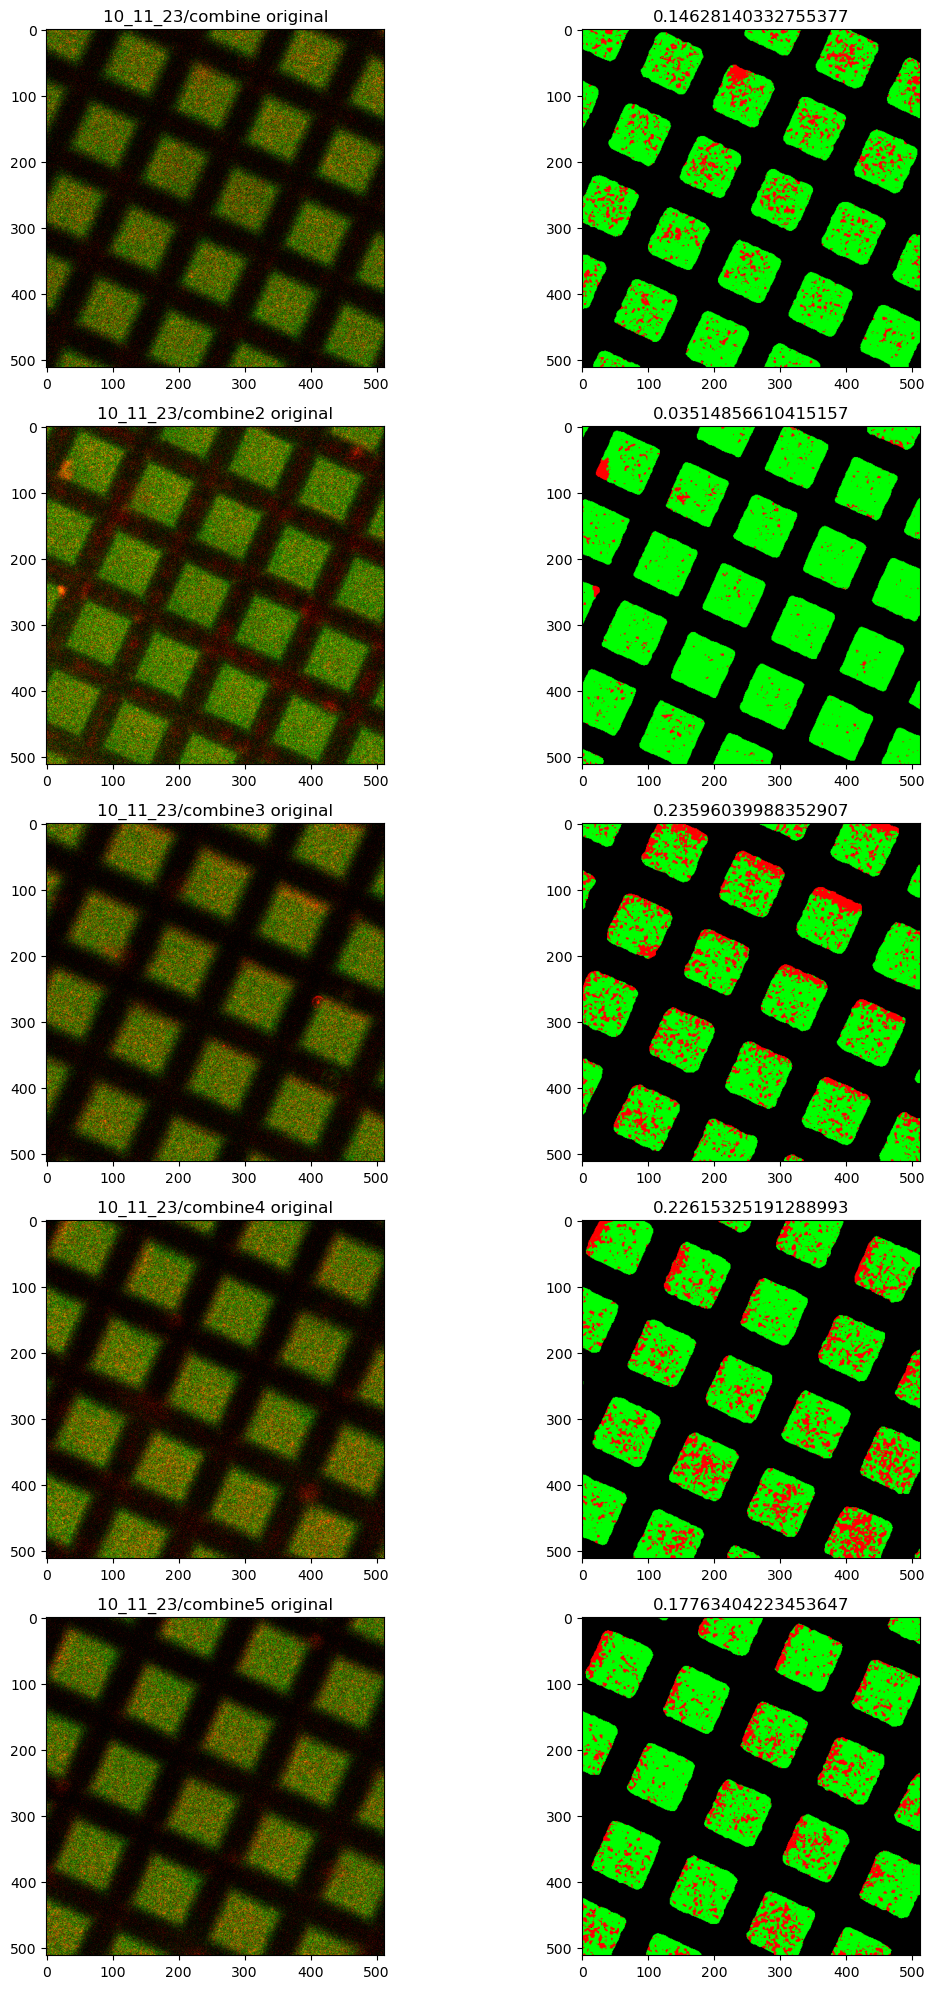

In [8]:
#with blur
fin = {}
fig, axs = plt.subplots(5, 2, figsize=(12, 20))  # Setting up a 5x2 grid of subplots, adjust figsize as needed
axs = axs.flatten()  # Flatten the axis array for easier indexing
plot_idx = 0  # Initialize plot index
box_size=4
for file in os.listdir("10_11_23"):
    if ('.nd2' not in file) or ('combine') not in file:
        continue
    file = "10_11_23/" + file
    with ND2Reader(file) as images:
            g=np.array(images[0])
            g=np.nan_to_num(g)
            r=np.array(images[1])
            r=np.nan_to_num(r)
            dataO=np.zeros((512, 512, 3))
            dataO[:,:,0]=(r/r.max())
            dataO[:,:,1]=(g/g.max())
            data=dataO.copy()
            g=boxcar(box_size,g)
            r=boxcar(box_size,r)
            #got the data
            rf=np.where(r>g,255,0)
            gf=np.where(g>r,255,0)
            #set the local binary in data before manipulation
            data[:,:,0]=rf
            data[:,:,1]=gf
            #now we use green as it has more data to blur, get an otzu, then use the threshold to get a mask
            scaled=(g/g.max())*255 #needed for filter
            blured=boxcar(7,scaled)
            ttemp=np.stack([blured,blured,blured],axis=2)
            t=color.rgb2gray(ttemp)
            thres=filters.threshold_otsu(t)
            t2 = np.where(t > thres,1,0)
            t3=np.stack([t2,t2,t2],axis=2)
            data=data*t3 #now mask the binerized data
            data=np.rint(data/data.max()) #bring it back to 0's and 1's as we already masked/scaled
            fin[file[:-4]]=data[:,:,0].sum()/(t2.sum())
            if file=='10_11_23/combine4.nd2':
                data_final=data
            # Plotting
            if plot_idx < 10:  # Ensure we don't try to plot more than 10 images
                axs[plot_idx].imshow(dataO)
                axs[plot_idx].set_title(file[:-4]+' original')
                plot_idx += 1  # Increment index

                axs[plot_idx].imshow(data)
                axs[plot_idx].set_title(f"{fin[file[:-4]]}")
                plot_idx += 1  # Increment index
            else:
                print(f"Skipping plotting for {file} as plot grid is full.")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("With_Blur.png")
plt.show()